In [2]:
import torch
import torchvision
from torch.utils.data import random_split, DataLoader
import torchvision.transforms as tt 
from torchvision.datasets import ImageFolder
import matplotlib
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torch.nn as nn
import numpy as np
%matplotlib inline

In [3]:
train_ds,valid_ds=  random_split(ImageFolder('./mnist_png/training',tt.ToTensor()),[50000,10000])
test_ds = ImageFolder('./mnist_png/testing',tt.ToTensor())

In [4]:
batch_size=50

In [5]:
train_dl=DataLoader(train_ds,batch_size,shuffle=True,num_workers=1,pin_memory=True)
valid_dl=DataLoader(valid_ds,batch_size,shuffle=True,num_workers=1,pin_memory=True)

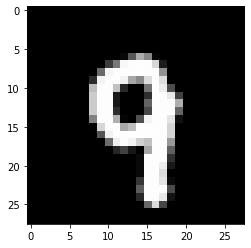

In [6]:
image,label=train_ds[0]
plt.imshow(image.permute(1,2,0),cmap='gray')  #looking at one sample of image

In [7]:
def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data,device):
    if isinstance(data,(list,tuple)):
        return (to_device(x,device) for x in data)
    return data.to(device,non_blocking=True)


In [8]:
class DeviceDataLoader():

    def __init__(self,dl,device):
        self.dl=dl
        self.device=device
    
    def __iter__(self):
        for b in self.dl:
            yield to_device(b,self.device)
    
    def __len__(self):
        return len(self.dl)


In [9]:
train_dl=DeviceDataLoader(train_dl,get_default_device())
valid_dl=DeviceDataLoader(valid_dl,get_default_device())

In [10]:
def accuracy(outputs,labels):
    _,preds=torch.max(outputs,dim=1)
    return torch.tensor(torch.sum(preds==labels).item()/len(preds))


In [11]:
class ImageClassificationBase(nn.Module):
    def training_step(self,batch):
        images,labels=batch
        out=self(images)
        loss = F.cross_entropy(out, labels)
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    
        loss = F.cross_entropy(out, labels)   
        acc = accuracy(out, labels)           
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()   
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_acc']))
        



In [12]:
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
              nn.BatchNorm2d(out_channels), 
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class CustomMNIST(ImageClassificationBase):
    def __init__(self, in_channels=3, num_classes=10):
        super().__init__()
        
        self.conv1 = conv_block(in_channels, 64) #64*28*28
        self.conv2 = conv_block(64, 128, pool=True) #128*14*14
        self.conv3 = conv_block(128,128,pool=True) #128*7*7
        self.classifier = nn.Sequential(nn.MaxPool2d(7),
                                        nn.Flatten(), 
                                        nn.Dropout(0.2),
                                        nn.Linear(128,num_classes))
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.conv3(out)
        out = self.classifier(out)
        return out
     
        

In [12]:
model = to_device(CustomMNIST(3, 10), get_default_device())
model

CustomMNIST(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): MaxPool2d(kernel_size=7, stride=7, padding=0, dilation=1, ceil_mode=False)
    (1): Flatten(start_dim=1, end_dim=-1)
    

In [13]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, 
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []
    
    # Set up cutom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, 
                                                steps_per_epoch=len(train_loader))
    
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        lrs = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            
            # Gradient clipping
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            
            optimizer.step()
            optimizer.zero_grad()
            
            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()
        
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [14]:
history = [evaluate(model, valid_dl)]
history

[{'val_loss': 2.304288625717163, 'val_acc': 0.08129999786615372}]

In [15]:
epochs = 5
max_lr = 0.001
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [16]:
%%time
history += fit_one_cycle(epochs, max_lr, model, train_dl, valid_dl, 
                             grad_clip=grad_clip, 
                             weight_decay=weight_decay, 
                             opt_func=opt_func)

Epoch [0], last_lr: 0.00076, train_loss: 0.8355, val_loss: 0.1384, val_acc: 0.9597
Epoch [1], last_lr: 0.00095, train_loss: 0.1656, val_loss: 0.0619, val_acc: 0.9816
Epoch [2], last_lr: 0.00061, train_loss: 0.1046, val_loss: 0.0442, val_acc: 0.9869
Epoch [3], last_lr: 0.00019, train_loss: 0.0696, val_loss: 0.0415, val_acc: 0.9873
Epoch [4], last_lr: 0.00000, train_loss: 0.0487, val_loss: 0.0349, val_acc: 0.9894
CPU times: user 10min 48s, sys: 3min 58s, total: 14min 47s
Wall time: 14min 48s


In [17]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

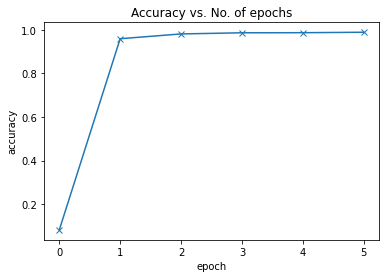

In [18]:
plot_accuracies(history)

In [19]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

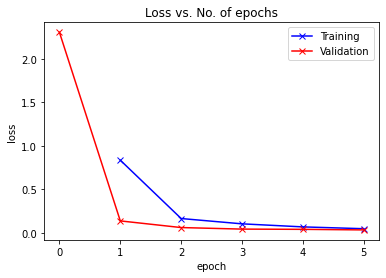

In [20]:
plot_losses(history)

In [21]:
def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.');

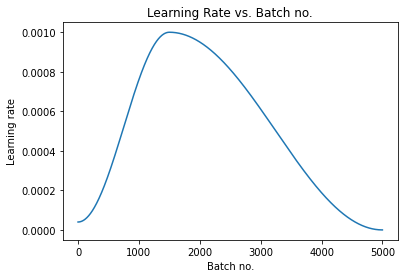

In [24]:
plot_lrs(history)

label given:  4 Prediced:  4


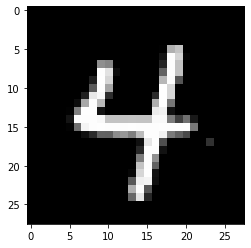

In [24]:
img, label = valid_ds[972]
plt.imshow(img.permute(1, 2, 0).clamp(0, 1))
yb=model(to_device(img.unsqueeze(0), get_default_device()))
_,pred= torch.max(yb,dim=1)
print("label given: ",label,"Prediced: ",pred.item())

In [29]:
model.parameters

<bound method Module.parameters of CustomMNIST(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): MaxPool2d(kernel_size=7, stride=7, padding=0, dilation=1, ceil_mode=False)
    (1): Fl

In [30]:
print("Model's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())


Model's state_dict:
conv1.0.weight 	 torch.Size([64, 3, 3, 3])
conv1.0.bias 	 torch.Size([64])
conv1.1.weight 	 torch.Size([64])
conv1.1.bias 	 torch.Size([64])
conv1.1.running_mean 	 torch.Size([64])
conv1.1.running_var 	 torch.Size([64])
conv1.1.num_batches_tracked 	 torch.Size([])
conv2.0.weight 	 torch.Size([128, 64, 3, 3])
conv2.0.bias 	 torch.Size([128])
conv2.1.weight 	 torch.Size([128])
conv2.1.bias 	 torch.Size([128])
conv2.1.running_mean 	 torch.Size([128])
conv2.1.running_var 	 torch.Size([128])
conv2.1.num_batches_tracked 	 torch.Size([])
conv3.0.weight 	 torch.Size([128, 128, 3, 3])
conv3.0.bias 	 torch.Size([128])
conv3.1.weight 	 torch.Size([128])
conv3.1.bias 	 torch.Size([128])
conv3.1.running_mean 	 torch.Size([128])
conv3.1.running_var 	 torch.Size([128])
conv3.1.num_batches_tracked 	 torch.Size([])
classifier.3.weight 	 torch.Size([10, 128])
classifier.3.bias 	 torch.Size([10])


In [32]:
torch.save(model.state_dict(),'./customMNIST')

In [20]:
model = CustomMNIST()
model.load_state_dict(torch.load('./customMNIST'))
model.eval()

CustomMNIST(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): MaxPool2d(kernel_size=7, stride=7, padding=0, dilation=1, ceil_mode=False)
    (1): Flatten(start_dim=1, end_dim=-1)
    